### COVID-19 Detection using VGG19 and X-ray Images
In this notebook, we aim to build a model to detect COVID-19 from X-ray images using the VGG19 architecture for transfer learning. The dataset used is the COVID-19 Radiography Database from Kaggle.

### Import Libraries
**Explanation:** Here, we import the necessary libraries required for data processing, model building, and evaluation. These include TensorFlow for deep learning, matplotlib for visualization, and others.

In [2]:
import cv2
import os
import warnings
import random
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm.keras import TqdmCallback

warnings.filterwarnings('ignore')

2024-07-07 20:44:01.098395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 20:44:01.098531: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 20:44:01.251963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
RANDOM_SEED = 29
random.seed(RANDOM_SEED)

In [4]:
covid_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
normal_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'

- Undersampling addresses class imbalance by reducing 'normal' images to match 'covid' samples, ensuring fair model training. 
- Initially shuffling and selecting 3,616 'normal' paths equalizes class representation. Subsequent inclusion of 'covid' images completes dataset balance, enhancing model learning across both classes for improved performance and generalization.

In [5]:
# normal    10192
# covid      3616

file_paths = []
labels = []
for filename in os.listdir(normal_path):
    file_paths.append(os.path.join(normal_path, filename))
    labels.append('normal')
random.shuffle(file_paths)
file_paths = file_paths[:3616]
labels = labels[:3616]
for filename in os.listdir(covid_path):
    file_paths.append(os.path.join(covid_path, filename))
    labels.append('covid')

In [6]:
len(file_paths)

7232

In [7]:
df = pd.DataFrame({'image': file_paths, 'class': labels})
df.head()

,image,class
0,/kaggle/input/covid19-radiography-database/COV...,normal
1,/kaggle/input/covid19-radiography-database/COV...,normal
2,/kaggle/input/covid19-radiography-database/COV...,normal
3,/kaggle/input/covid19-radiography-database/COV...,normal
4,/kaggle/input/covid19-radiography-database/COV...,normal


In [8]:
df = df.sample(frac = 1)
df.head()

,image,class
1265,/kaggle/input/covid19-radiography-database/COV...,normal
1553,/kaggle/input/covid19-radiography-database/COV...,normal
4437,/kaggle/input/covid19-radiography-database/COV...,covid
3771,/kaggle/input/covid19-radiography-database/COV...,covid
3249,/kaggle/input/covid19-radiography-database/COV...,normal


In [9]:
df['class'].value_counts()

class
normal    3616
covid     3616
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7232 entries, 1265 to 6460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7232 non-null   object
 1   class   7232 non-null   object
dtypes: object(2)
memory usage: 169.5+ KB


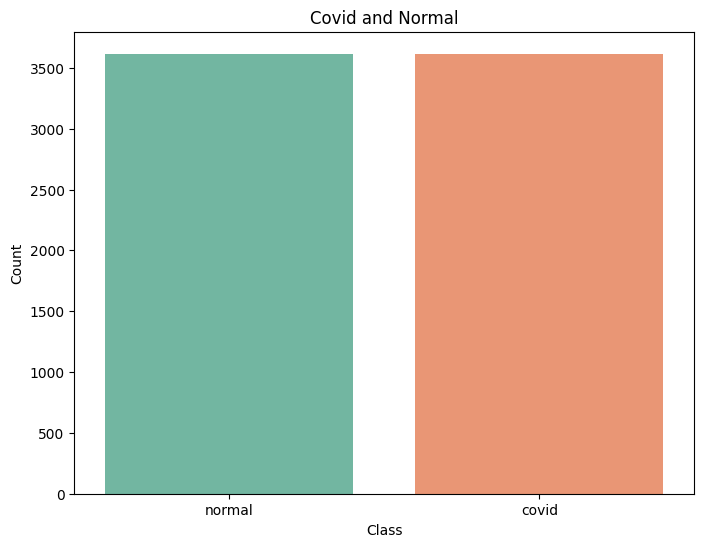

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='Set2')
plt.title('Covid and Normal')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

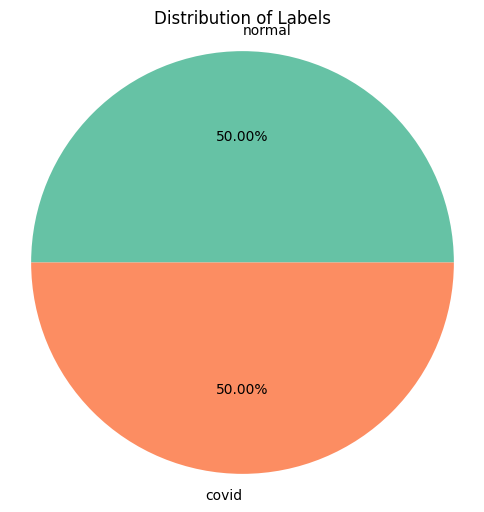

In [12]:
label_counts = df['class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%', colors=sns.color_palette('Set2'))
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

In [13]:
def convert_image(image):
    img = cv2.imread(image)
    img = img_to_array(img)
    img = cv2.resize(img, (224, 224))
    return (img)


In [14]:
df['processed_image'] = df['image'].apply(convert_image)

In [15]:
df.head()

,image,class,processed_image
1265,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[226.53745, 226.53745, 226.53745], [206.3273..."
1553,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[2.171875, 2.171875, 2.171875], [2.171875, 2..."
4437,/kaggle/input/covid19-radiography-database/COV...,covid,"[[[46.793156, 46.793156, 46.793156], [16.27830..."
3771,/kaggle/input/covid19-radiography-database/COV...,covid,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3249,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[3.502232, 3.502232, 3.502232], [5.5855637, ..."


In [16]:
le = LabelEncoder()
df['processed_class'] = le.fit_transform(df['class'])
df['processed_class'].unique()

array([1, 0])

In [17]:
df.head()

,image,class,processed_image,processed_class
1265,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[226.53745, 226.53745, 226.53745], [206.3273...",1
1553,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[2.171875, 2.171875, 2.171875], [2.171875, 2...",1
4437,/kaggle/input/covid19-radiography-database/COV...,covid,"[[[46.793156, 46.793156, 46.793156], [16.27830...",0
3771,/kaggle/input/covid19-radiography-database/COV...,covid,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
3249,/kaggle/input/covid19-radiography-database/COV...,normal,"[[[3.502232, 3.502232, 3.502232], [5.5855637, ...",1


In [18]:
x = np.stack(df['processed_image'].values)
y = np.array(df['processed_class']).reshape(-1, 1)


In [19]:
print(len(x))
print(x.shape)
print(y.shape)

7232
(7232, 224, 224, 3)
(7232, 1)


In [20]:
x_train, x_test,y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=RANDOM_SEED)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=RANDOM_SEED)

In [21]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6508, 224, 224, 3)
(145, 224, 224, 3)
(579, 224, 224, 3)


In [22]:
x_train = x_train / 255
x_test_scaled = x_test / 255
x_val = x_val / 255

### Build the Model using VGG19
**Explanation:** 
- **Transfer Learning:** We use the pre-trained VGG19 model which has been trained on a large dataset (ImageNet). This helps in leveraging the learned features from a different domain to our specific task of COVID-19 detection.
- **Model Architecture:** We add custom layers on top of VGG19 to adapt it to our classification problem. This includes flattening the output, adding dense layers, and a final softmax layer for classification.

In [23]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    flatten_layer = Flatten()(base_model.output)
    dense_layer1 = Dense(1024, activation='relu')(flatten_layer)
    dense_layer2 = Dense(512, activation='relu')(dense_layer1)
    output_layer = Dense(1, activation='sigmoid')(dense_layer2)

    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

In [24]:
model = build_model()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 46,240,833 (176.39 MB)

 Trainable params: 26,216,449 (100.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

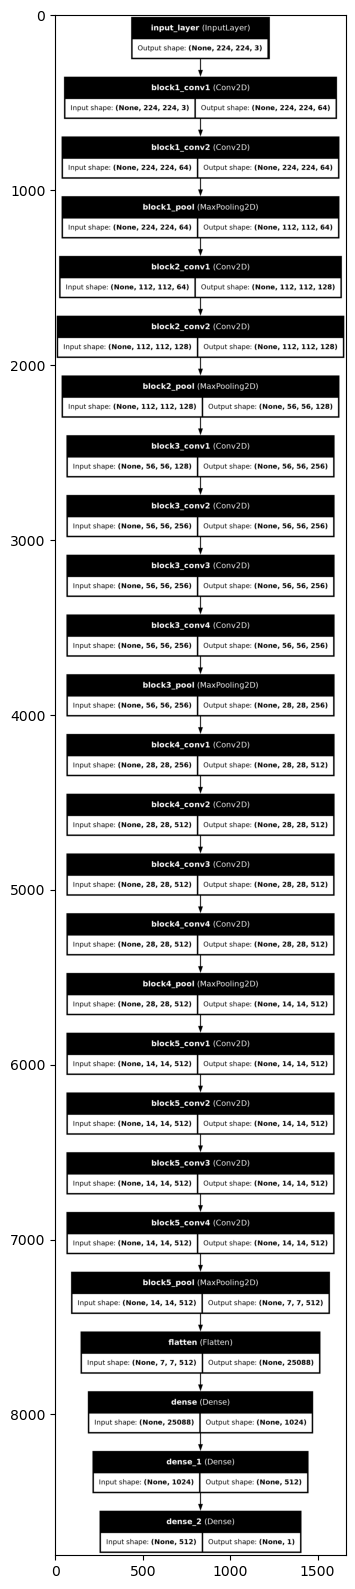

In [4]:
model_plot = Image.open('model_plot.png')
plt.figure(figsize=(30, 20))
plt.imshow(model_plot)

### Compile the Model
**Explanation:** 
- **Loss Function:** We use 'binary_crossentropy' as the loss function because we have two classes.
- **Optimizer:** We use the Adam optimizer which adjusts the learning rate dynamically.
- **Metrics:** We track accuracy, precision, recall and binary_accuracy to monitor the performance of the model.

In [27]:
EPOCHS = 40
initial_lr = 1e-5
decay_steps = 10
decay_rate = 1.0

lr_scheduler = ExponentialDecay(initial_lr, decay_steps, decay_rate)
training_optimizer = Adam(learning_rate=lr_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=training_optimizer, loss='binary_crossentropy', metrics=['accuracy','precision','recall','auc','binary_accuracy'])

### Train the Model
**Explanation:** 
- **Epochs:** Number of times the entire training dataset is passed forward and backward through the neural network.
- **Batch Size:** Number of training examples utilized in one iteration.
- **Validation Data:** Helps in monitoring the model's performance on unseen data during training to tune hyperparameters and avoid overfitting.

In [28]:
history = model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping, TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

I0000 00:00:1720385220.728965     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720385220.755687     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720385264.454326     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720385266.172561     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720385284.676634     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

  0%|          | 0.00/204 [00:00<?, ?batch/s]

In [30]:
save_path = '/kaggle/working/covid-model.h5'
model.save(save_path)

In [31]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### Visualize Training Results
**Explanation:** 
- **Loss and Accuracy Plots:** Visualize the training and validation loss and accuracy to understand how well the model is learning and if it's overfitting or underfitting.
- **Confusion Matrix:** Provides a detailed breakdown of true positives, false positives, true negatives, and false negatives, giving insights into where the model is making errors.

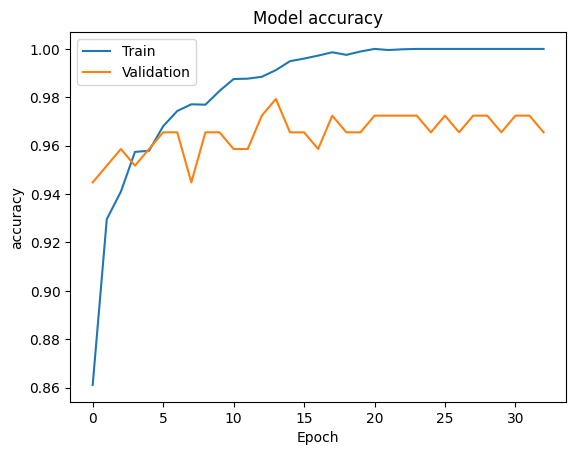

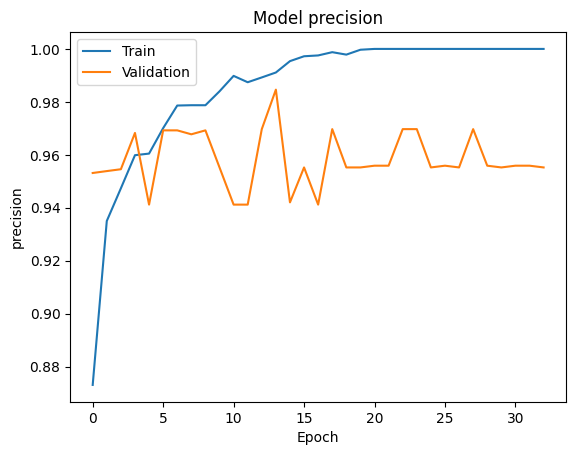

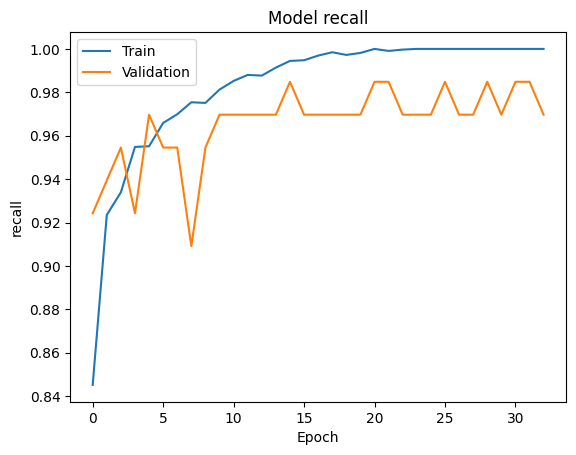

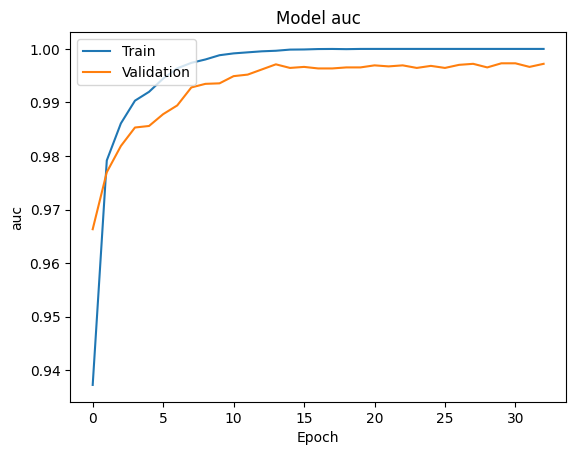

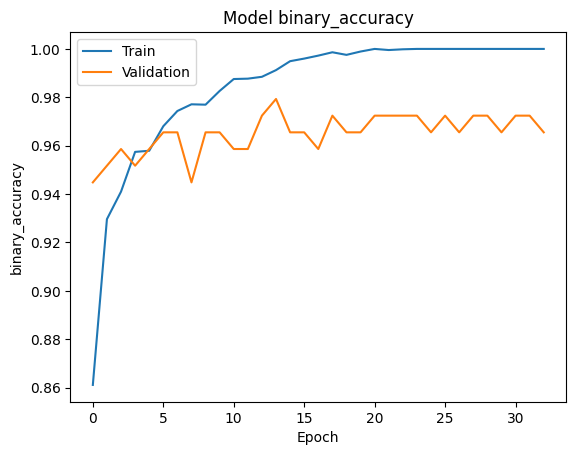

In [32]:
metrics=['accuracy','precision','recall','auc','binary_accuracy']

for metric in metrics:
    plot_metric(metric)

In [34]:
y_pred = model.predict(x_test_scaled)
y_predict = [1 if elem >= 0.5 else 0 for elem in y_pred]

y_pred = y_predict
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Accuracy:  0.9810017271157168


The high accuracy of **0.9810017271157168** demonstrates the effectiveness of the VGG19 model with transfer learning in detecting COVID-19 from X-ray images. This reflects the successful application of data preprocessing, augmentation, and model training techniques.

In [35]:
report = classification_report(y_test, y_pred, target_names=['covid', 'normal'])
report

'              precision    recall  f1-score   support\n\n       covid       0.96      1.00      0.98       284\n      normal       1.00      0.96      0.98       295\n\n    accuracy                           0.98       579\n   macro avg       0.98      0.98      0.98       579\nweighted avg       0.98      0.98      0.98       579\n'

[[284   0]
 [ 11 284]]


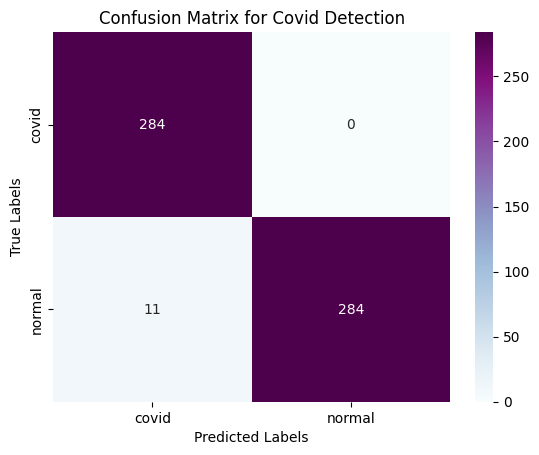

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu')

labels = ['covid', 'normal']
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Covid Detection')
plt.show()

In [39]:
df.iloc[0, 2].shape

(224, 224, 3)

In [44]:
def show_predictions(n):
    for _ in range(n):
        random_index = random.randint(0, len(df) - 1)
        random_row = df.iloc[random_index]
        image_path = random_row['image']
        label = random_row['class']

        prediction = model.predict(np.expand_dims(random_row['processed_image'] / 255.0, axis=0))
        prediction = 'normal' if prediction >= 0.5 else 'covid' 
        img = Image.open(image_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f'Prediction: {prediction}, Label: {label}')
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


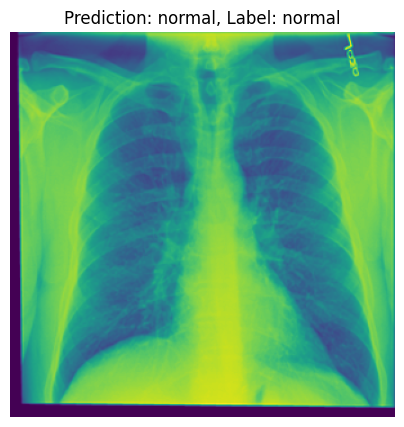

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


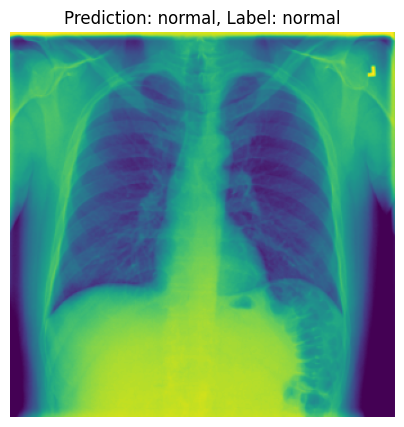

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


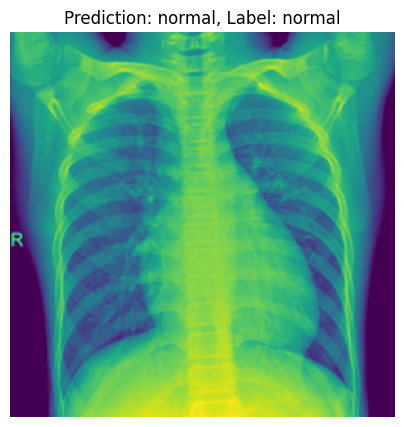

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


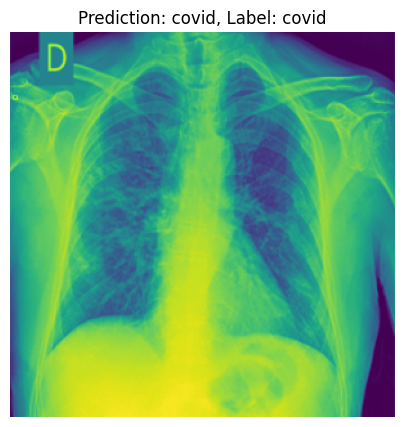

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


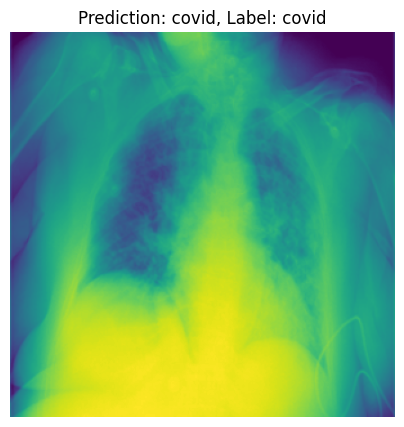

In [45]:
show_predictions(5)